## Logistic 回归模型
虽然也被称为回归，但是其更多的情况使用在分类问题上，同时又以二分类更为常用
Logistic 回归的模型形式和线性回归一样，都是 y = wx + b，其中 x 可以是一个多维的特征，唯一不同的地方在于 Logistic 回归会对 y 作用一个 logistic 函数，将其变为一种概率的结果。 Logistic 函数作为 Logistic 回归的核心也被称为 Sigmoid 函数  
sigmoid函数：$$
f(x) = \frac{1}{1 + e^{-x}}
$$
  
### loss 函数
  
$$
loss = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))
$$  

其中 y 表示真实的 label，只能取 {0, 1} 这两个值，因为 $\hat{y}$ 表示经过 Logistic 回归预测之后的结果，是一个 0 ~ 1 之间的小数。  
如果 y 是 0，表示该数据属于第一类，我们希望 $\hat{y}$ 越小越好，上面的 loss 函数变为

$$
loss = - (log(1 - \hat{y}))
$$
在训练模型的时候我们希望最小化 loss 函数，根据 log 函数的单调性，也就是最小化 $\hat{y}$，与我们的要求是一致的。

而如果 y 是 1，表示该数据属于第二类，我们希望 $\hat{y}$ 越大越好，同时上面的 loss 函数变为

$$
loss = -(log(\hat{y}))
$$
我们希望最小化 loss 函数也就是最大化 $\hat{y}$，这也与我们的要求一致。

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 设定随机种子
torch.manual_seed(2018)

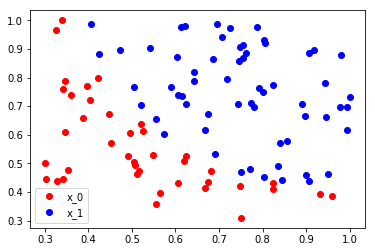

In [3]:
# 从 data.txt 中读入点
with open('./data.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()] #取序列为0的项
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]
# 标准化
x0_max = max([i[0] for i in data])
x1_max = max([i[1] for i in data])
data = [(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]

x0 = list(filter(lambda x: x[-1] == 0.0, data)) # 选择第一类的点
x1 = list(filter(lambda x: x[-1] == 1.0, data)) # 选择第二类的点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [4]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = torch.from_numpy(np_data[:, 0:2]) # 转换成 Tensor, 大小是 [100, 2]
y_data = torch.from_numpy(np_data[:, -1]).unsqueeze(1) # 转换成 Tensor，大小是 [100, 1]  取列

In [5]:
x_data = Variable(x_data)
y_data = Variable(y_data)
#通过导入 torch.nn.functional 来使用sigmoid

import torch.nn.functional as F 
# 定义 logistic 回归模型
w = Variable(torch.randn(2, 1), requires_grad=True) 
b = Variable(torch.zeros(1), requires_grad=True)

def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)

In [6]:
# 计算loss
def binary_loss(y_pred, y):
    logits = (y * y_pred.clamp(1e-12).log() + (1 - y) * (1 - y_pred).clamp(1e-12).log()).mean()
    return -logits

参数更新方式其实是繁琐的重复操作，如果我们的参数很多，比如有 100 个，那么我们需要写 100 行来更新参数，为了方便，我们可以写成一个函数来更新，其实 PyTorch 已经为我们封装了一个函数来做这件事，这就是 PyTorch 中的优化器 torch.optim

使用 torch.optim 需要另外一个数据类型，就是 nn.Parameter，这个本质上和 Variable 是一样的，只不过 nn.Parameter 默认是要求梯度的，而 Variable 默认是不求梯度的

使用 torch.optim.SGD 可以使用梯度下降法来更新参数，PyTorch 中的优化器有更多的优化算法，后面会更加详细的介绍

将参数 w 和 b 放到 torch.optim.SGD 中之后，说明一下学习率的大小，就可以使用 optimizer.step() 来更新参数了，比如下面我们将参数传入优化器，学习率设置为 1.0

In [7]:
# 使用 torch.optim 更新参数
from torch import nn
w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_regression(x):
    return torch.sigmoid(torch.mm(x, w) + b)

optimizer = torch.optim.SGD([w, b], lr=1.)

In [8]:
# 进行 1000 次更新
for e in range(1000):
    # 前向传播
    y_pred = logistic_regression(x_data)
    loss = binary_loss(y_pred, y_data) # 计算 loss
    # 反向传播
    optimizer.zero_grad() # 使用优化器将梯度归 0
    loss.backward()
    optimizer.step() # 使用优化器来更新参数
    # 计算正确率
    mask = y_pred.ge(0.5).float()
    acc = (mask == y_data).sum().item()/ y_data.shape[0]
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(e+1, loss.data[0], acc))

C:\Users\zhangwx\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


epoch: 200, Loss: 0.40997, Acc: 0.92000
epoch: 400, Loss: 0.32991, Acc: 0.92000
epoch: 600, Loss: 0.29353, Acc: 0.91000
epoch: 800, Loss: 0.27258, Acc: 0.91000
epoch: 1000, Loss: 0.25889, Acc: 0.90000


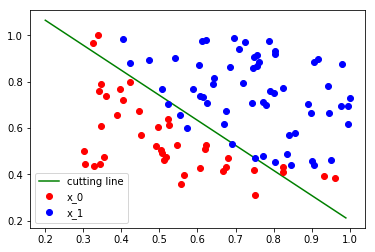

In [9]:
# 画出更新之后的结果
w0 = w[0].data[0].numpy()
w1 = w[1].data[0].numpy()
b0 = b.data[0].numpy()

plot_x = np.arange(0.2, 1, 0.01)
plot_y = ((-w0 * plot_x )- b0) / w1


plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

前面我们使用了自己写的 loss，其实 PyTorch 已经为我们写好了一些常见的 loss，比如线性回归里面的 loss 是 nn.MSE()，而 Logistic 回归的二分类 loss 在 PyTorch 中是 nn.BCEWithLogitsLoss()

另外，PyTorch 出于稳定性考虑，将模型的 Sigmoid 操作和最后的 loss 都合在了 nn.BCEWithLogitsLoss()，所以我们使用 PyTorch 自带的 loss 就不需要再加上 Sigmoid 操作了

In [10]:
# 使用自带的loss
criterion = nn.BCEWithLogitsLoss() # 将 sigmoid 和 loss 写在一层，有更快的速度、更好的稳定性

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_reg(x):
    return torch.mm(x, w) + b

optimizer = torch.optim.SGD([w, b], 1.)

In [11]:
# 同样进行 1000 次更新

for e in range(1000):
    # 前向传播
    y_pred = logistic_reg(x_data)
    loss = criterion(y_pred, y_data)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 计算正确率
    mask = y_pred.ge(0.5).float()
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(e+1, loss.data[0], acc))


C:\Users\zhangwx\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


epoch: 200, Loss: 0.39586, Acc: 0.88000
epoch: 400, Loss: 0.32426, Acc: 0.87000
epoch: 600, Loss: 0.29049, Acc: 0.87000
epoch: 800, Loss: 0.27067, Acc: 0.87000
epoch: 1000, Loss: 0.25758, Acc: 0.88000
